## Clustering and Analyzing Panamá Smart City Locations
**Author**: ***Kenry A. Sanchez Vento***

### From Problem to Approach

Let's say The Marketing Department of Liberty Technologies Corp. wants to know which industries, stores or Malls are being benefited of the `Paradas Smart City` which are some places of the city with Free Wi-Fi and a radio of 7 meters. The company is responsible of the installation of any Free Point around the city and are the owners of the access points.

They want to know which places are around the Free Wi-Fi point for that way offer to those companies their portal access as a point for gain more clients. For Example:

- offer discounts to be used on local stores.
- offer some events like expositions.
- visit tourist places.

In this way, they want to know the answer to these questions:

1. How are distributed the points around the city?
2. How are segmented the points?
3. Is there a way to clustering or segmenting the points using attributes like kind of place, store, etc.?
4. Which are the most commons kind of place around the points?

In a Business Focus, not just for the Liberty Technologies Corp, understand the segmentation of any store or merchandise around the place can help to other companies (usually, most be the businesses around the Wi-Fi points) to make marketing strategies in based on those places. In fact, they could support a business strategy in alliance with Department of Liberty Technologies Corp. which is the responsable of the wifi points.

### Making an Approach

The accuracy of the solution will be in the accuracy of any point around the city and also in the most update localization map. So, in this way we can recover data from locations and an explorer map to undestand how are the points distributed and which are the interested places. With all of these we can build a clustering map based on the points and get knowledge about what we want to know.

**Analytic Approach**

Descriptive and Statical Analytics

### Data Requirements

The data we're going to use to solve our problem will be:

#### Smart City Point

Data with all the localizations of any Smart City Point around the City. This data is current available from `Portal de Datos Abiertos de la Alcaldia de Panamá` (Open Data Portal from Panama City town Hall). https://datos-geomupa.opendata.arcgis.com/datasets/paradas-smartcity-p

**Atributes**

- **LATITUDE**: Latitude of the point.
- **LONGITUDE**: Longuitude of the point.
- **NAME**: Name of the place.
- **OBJECTID**: Id of the row.

#### Exploration Data

Exploration data serviced by Foursquare Api. We're a going to use standart web client which is perfect for get all the places around the city.

**Atributes**

- **ID**: Id of the row.
- **NAME**: Name of the place.
- **LOCATION**
- **CATEGORIES**: Attributes to define the place. It's based on the categories distribution by Foursquare Api.

### Data Collection

Let's create our Smart City Point Data Frame to then make a Folium Map with the distribution of the points around Panamá City. We should see the dimension (rows x columns) and check out the latitude and longitude per row.

In [283]:
## initializing import dependencies
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import requests as rq
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize

In [284]:
wifi_pd = pd.read_csv("https://opendata.arcgis.com/datasets/e060c910d212484685f6c23cfff2a0d1_0.csv")
wifi_pd.head()

,X,Y,OBJECTID,Nombre
0,-79.535111,8.962863,1,Cinta Costera
1,-79.528691,8.972058,2,Cinta Costera
2,-79.521034,8.974748,3,Cinta Costera
3,-79.517021,8.975585,4,"Avenida Balboa, frente a Multicentro"
4,-79.527694,8.974871,5,"Avenida Balboa, junto a él Parque Urracá"


In [285]:
## find nan values and then delete it
wifi_pd.isna()
print(wifi_pd.shape)

(44, 4)


In [286]:
wifi_pd.dropna(inplace = True)
wifi_pd.reset_index(drop=True, inplace=True)

wifi_pd[:10]

,X,Y,OBJECTID,Nombre
0,-79.535111,8.962863,1,Cinta Costera
1,-79.528691,8.972058,2,Cinta Costera
2,-79.521034,8.974748,3,Cinta Costera
3,-79.517021,8.975585,4,"Avenida Balboa, frente a Multicentro"
4,-79.527694,8.974871,5,"Avenida Balboa, junto a él Parque Urracá"
5,-79.532083,8.968543,9,"Avenida Balboa, junto a el Hospital de Niño"
6,-79.538670,8.966836,11,"Avenida Perú, frente a el Machetazo"
7,-79.532628,8.973096,15,"Avenida Justo Arosemena, frente a el Hospital ..."
8,-79.520209,8.982071,20,"Calle 50, Plaza New York"
9,-79.523088,8.980358,21,"Calle 50, junto a la Defensoria del Pueblo"


In [287]:
print(wifi_pd.shape)

(43, 4)


As we see, there are `43` public points with Free Wi-Fi around the city.

In [288]:
## Find duplicate name points and then change it's name
wifi_pd[wifi_pd['Nombre'].duplicated(keep = False)]

,X,Y,OBJECTID,Nombre
0,-79.535111,8.962863,1,Cinta Costera
1,-79.528691,8.972058,2,Cinta Costera
2,-79.521034,8.974748,3,Cinta Costera
32,-79.533981,9.009629,47,"Tumba Muerto, Centro Comercial al Dorado"
34,-79.534493,9.009785,49,"Tumba Muerto, Centro Comercial al Dorado"


In [289]:
wifi_pd.at[1, 'Nombre'] = "{} {}".format(wifi_pd.iloc[1]['Nombre'], "B")
wifi_pd.at[2, 'Nombre'] =  "{} {}".format(wifi_pd.iloc[2]['Nombre'], "C")
wifi_pd.at[32, 'Nombre'] = "{} {}".format(wifi_pd.iloc[32]['Nombre'], "B")

In [290]:
## There wont be more duplicated
wifi_pd['Nombre'].is_unique
print(wifi_pd.shape)

(43, 4)


### Folium Map with distribution points

In [291]:
import folium # map rendering library

from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

In [292]:
##geoapy app
geoapy_app = Nominatim(user_agent="geoapy_panama")
location = geoapy_app.geocode("Panamá City")

# define the world map
world_map = folium.Map([location.latitude, location.longitude], zoom_start=12)

##define markers
markers = folium.map.FeatureGroup()

for lat, lon in zip(wifi_pd.Y, wifi_pd.X):
    markers.add_child(folium.features.CircleMarker(
        [lat, lon],
        radius = 5,
        fill = True,
        color = "yellow",
        fill_opacity = 0.6,
        fill_color = 'blue'
    ))

#pop up with name marker
latitudes = list(wifi_pd.Y)
longitudes = list(wifi_pd.X)
labels = list(wifi_pd['Nombre'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label[:15]).add_to(world_map)   

world_map.add_child(markers)

### Exploration Data using Foursquare API

First, we need to define a radio for our search avenue. We want to select any place close to our points. For this initial approachment, taking into consideration we don't have any studio about which places people decide to visit close to the Wi-Fi Points and how often they decide it, we're going to choose a `default radio for our test`. We're going to say (based on The Hurwicz Criterion) people are able to walk to from the wifi point to any place near by `250 meters` when there is a special occasion, as an example, a special discount or an event. As every Wi-Fi Point has a radio of 7 meters, that means people don't need to be in the centric of the point to access to the portal and then see the advertisement. So, we are going to start with a radio of `257 meters`.

In [293]:
##geoapy app
geoapy_app = Nominatim(user_agent="geoapy_panama")
location = geoapy_app.geocode("Panamá City")

# define the world map
world_map = folium.Map([location.latitude, location.longitude], zoom_start=12)

##define markers
markers = folium.map.FeatureGroup()

for lat, lon in zip(wifi_pd.Y, wifi_pd.X):
    markers.add_child(folium.features.CircleMarker(
        [lat, lon],
        radius = 7,
        fill = True,
        color = "yellow",
        fill_opacity = 0.6,
        fill_color = 'blue'
    ))
    
    folium.Circle(
    radius=257,
    location=[lat, lon],
    color='crimson',
    fill=True,
     ).add_to(world_map)

#pop up with name marker
latitudes = list(wifi_pd.Y)
longitudes = list(wifi_pd.X)
labels = list(wifi_pd['Nombre'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label[:20]).add_to(world_map)   

world_map.add_child(markers)

Looking at the Map we can define some approaches from our studio:

- The Wifi Points are distributed from the west to east of the city.
- Some Wifi Points share avenues with anothers. As an example Cinta Costera and Avenida Balboa.
- There are 2 Points far away of the center of the city which are at Av. José A. Arango.
- The majority of points are at the west of the city.

Now it's time to collect our exploration data using Foursquare API. I'm going to take into consideration all the points for this first approach.

In [294]:
def getNearbyVenues(names, latitudes, longitudes, radius=257):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            "MRCNLEHWXALYJP4MY0M2GAU213XLSP5FBNN2A3XG4JRIA4N1", 
            "4B3HRVHQ2KCLKZ4WONEOE5POKS5TTQGYPTYLIJZMHFV0LMWS", 
            "20180605", 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = rq.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Smart Point Name',
                  'Smart Point Latitude', 
                  'Smart Point Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [295]:
pd_smart_places = getNearbyVenues(names=wifi_pd['Nombre'], latitudes=wifi_pd['Y'], longitudes=wifi_pd['X'])
pd_smart_places[:20]

,Smart Point Name,Smart Point Latitude,Smart Point Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cinta Costera,8.962863,-79.535111,Rompeolas,8.963043,-79.534424,Scenic Lookout
1,Cinta Costera,8.962863,-79.535111,Mirador del Pacífico,8.961869,-79.534606,Park
2,Cinta Costera,8.962863,-79.535111,Rompe Olas,8.961288,-79.535632,Scenic Lookout
3,Cinta Costera,8.962863,-79.535111,Teatro ASSA,8.963983,-79.535063,Theater
4,Cinta Costera,8.962863,-79.535111,Fermin Chan,8.963147,-79.536813,Clothing Store
5,Cinta Costera B,8.972058,-79.528691,Cinta Costera,8.971261,-79.529514,Scenic Lookout
6,Cinta Costera B,8.972058,-79.528691,4 Bistro,8.970984,-79.529836,Bakery
7,Cinta Costera B,8.972058,-79.528691,IGA,8.972812,-79.530133,Bakery
8,Cinta Costera B,8.972058,-79.528691,auto plaza LUXURY MOTORS,8.972521,-79.526428,Auto Garage
9,Cinta Costera C,8.974748,-79.521034,Segundo Muelle,8.975817,-79.520663,Seafood Restaurant


In [296]:
print(pd_smart_places.shape)

(583, 7)


In [297]:
## making categorical rows per avenue
pd_smart_places_coding = pd.get_dummies(pd_smart_places['Venue Category'], prefix="", prefix_sep="")
pd_smart_places_coding["Smart Point Name"] = pd_smart_places["Smart Point Name"]

In [298]:
# pd_smart_places_coding
pd_smart_places_coding_grouped = pd_smart_places_coding.groupby('Smart Point Name').mean().reset_index()
pd_smart_places_coding_grouped

,Smart Point Name,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Beach,...,Track,Travel Lounge,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Av. José A. Arango, frente al Macdonals",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Av. José A. Arango, junto al Super Xtra de Los...",0.142857,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Avenida Balboa, frente a Multicentro",0.066667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.100000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333
3,"Avenida Balboa, junto a el Hospital de Niño",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Avenida Balboa, junto a él Parque Urracá",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Avenida Justo Arosemena, frente a el Hospital ...",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Avenida Perú, frente a el Machetazo",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Calle 50, Plaza New York",0.000000,0.030303,0.000000,0.030303,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Calle 50, junto Torre Global Bank",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Calle 50, junto a la Defensoria del Pueblo",0.040000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [299]:
print(pd_smart_places_coding_grouped.shape)
print(wifi_pd.shape)

(42, 129)
(43, 4)


If we compare the dataframes `pd_smart_places_coding_grouped` and `wifi_pd`, we notice that the row lost is the smart point `Transístmica, junto a Escuela de Artes y Oficios`. Apparently, Foursquare cannot recover that point. To be sure, we must make a new custom request with only that point.

In [300]:
pd_smart_places[pd_smart_places['Smart Point Name'] == 'Transístmica, junto a Escuela de Artes y Oficios']

,Smart Point Name,Smart Point Latitude,Smart Point Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [301]:
key = 'Transístmica, junto a Escuela de Artes y Oficios'
radius = 257
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            "MRCNLEHWXALYJP4MY0M2GAU213XLSP5FBNN2A3XG4JRIA4N1", 
            "4B3HRVHQ2KCLKZ4WONEOE5POKS5TTQGYPTYLIJZMHFV0LMWS", 
            "20180605", 
            wifi_pd[wifi_pd['Nombre'] == key]['Y'], 
            wifi_pd[wifi_pd['Nombre'] == key]['X'], 
            radius, 
            100)

# make the GET request
results = rq.get(url).json()["response"]
results

{}

Yes, Foursquare cannot recover that point. In this case, we should remove that point in the final map report.

In [302]:
##remove useless row
wifi_pd = wifi_pd[wifi_pd['Nombre'] != 'Transístmica, junto a Escuela de Artes y Oficios']
wifi_pd = wifi_pd.sort_values(by=['Nombre']).reset_index()

### Data Analysis

Now, it's time to make our analysis and discover the most commons kind of place around the points. The idea is:

- Discover commons categories and avenues.
- If we notice a point that is useless for our final model, remove it.
- Prepare an idea about how could be segmented the smart points around the city.

In [303]:
##new dataframe and display the top 10 venues for each neighborhood.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Smart Point Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
smart_points_venues_sorted = pd.DataFrame(columns=columns)
smart_points_venues_sorted['Smart Point Name'] = pd_smart_places_coding_grouped['Smart Point Name']

for ind in np.arange(pd_smart_places_coding_grouped.shape[0]):
    smart_points_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pd_smart_places_coding_grouped.iloc[ind, :], num_top_venues)

smart_points_venues_sorted

,Smart Point Name,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,"Av. José A. Arango, frente al Macdonals",Department Store,Restaurant,Fast Food Restaurant,Shopping Mall,Latin American Restaurant,Sporting Goods Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court
1,"Av. José A. Arango, junto al Super Xtra de Los...",American Restaurant,Sporting Goods Shop,Fast Food Restaurant,Restaurant,Department Store,Shopping Mall,Italian Restaurant,Bakery,Gift Shop,Factory
2,"Avenida Balboa, frente a Multicentro",Bar,Hotel,American Restaurant,Cocktail Bar,Lounge,Pool,Pizza Place,Pharmacy,Park,Nightclub
3,"Avenida Balboa, junto a el Hospital de Niño",Diner,Indie Movie Theater,Gay Bar,Drugstore,Electronics Store,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court
4,"Avenida Balboa, junto a él Parque Urracá",Mexican Restaurant,Bar,Park,Café,Buffet,Restaurant,Tapas Restaurant,Gym,Pub,Hotel
5,"Avenida Justo Arosemena, frente a el Hospital ...",Sandwich Place,Hotel,Gastropub,Pharmacy,Food Court,Gas Station,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
6,"Avenida Perú, frente a el Machetazo",Hotel,Latin American Restaurant,Furniture / Home Store,Grocery Store,Yoga Studio,Food Court,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Farmers Market
7,"Calle 50, Plaza New York",Hotel,Shopping Mall,Hostel,Italian Restaurant,Restaurant,Food Court,Coffee Shop,Sandwich Place,Dessert Shop,Peruvian Restaurant
8,"Calle 50, junto Torre Global Bank",Italian Restaurant,Playground,Brazilian Restaurant,Pastry Shop,Bakery,Drugstore,Restaurant,Farmers Market,Falafel Restaurant,Fast Food Restaurant
9,"Calle 50, junto a la Defensoria del Pueblo",Hotel,Coffee Shop,Italian Restaurant,Restaurant,American Restaurant,Sports Bar,Latin American Restaurant,Greek Restaurant,Lounge,Massage Studio


We see in the dataframe the 10 most commons category of places around the smart points. If we make a quickly analysis, we can notice that places like `Food, Hotels and Stores` are in first position. Now, we must clustering this dataframe to then segment our smart city locatio

### Modeling Smart City Cluster

We're going to use a K-Means Machine Learning model to modeling our data into a cluster and then analyze our segmentation.

In [304]:
from sklearn.cluster import KMeans

In [305]:
## init configuration
k_list = []
n_list = 15

df_clustering_points = pd_smart_places_coding_grouped.copy()
df_clustering_points.drop('Smart Point Name', axis = 1, inplace = True)

for k in np.arange(1, n_list):
    k_model = KMeans(init="k-means++", n_init=12, n_clusters = k, random_state=0).fit(df_clustering_points)
    k_list.append(k_model.inertia_)

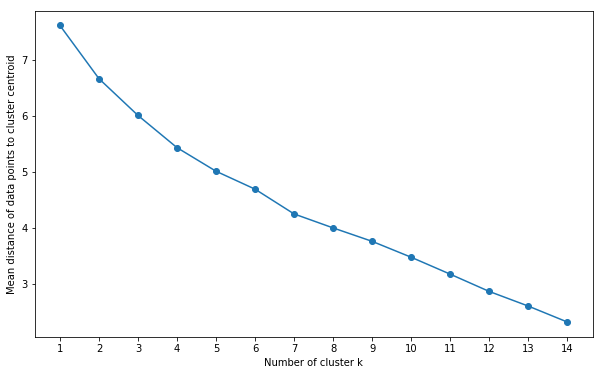

In [306]:
##ploting elbow line
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_list), k_list, '-o')
plt.ylabel("Mean distance of data points to cluster centroid")
plt.xlabel("Number of cluster k")
plt.xticks(np.arange(1, n_list))
plt.show()

I choose `k=6` as the elbow. In that way, we have 6 centroids which means 6 cluster segmentations

In [307]:
k_model = KMeans(init="k-means++", n_init=12, n_clusters = 6, random_state=0).fit(df_clustering_points)
k_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [308]:
k_model.labels_

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 2,
       0, 0, 1, 4, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [309]:
df_clustering_points.insert(0, 'Cluster Labels', k_model.labels_)

In [310]:
df_clustering_points

,Cluster Labels,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Beach,...,Track,Travel Lounge,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.142857,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,0.066667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.100000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333
3,3,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0,0.000000,0.030303,0.000000,0.030303,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0,0.040000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Mapping Cluster into Folium

In [311]:
##geoapy app
geoapy_app = Nominatim(user_agent="geoapy_panama")
location = geoapy_app.geocode("Panamá City")

# define the world map
map_clusters = folium.Map([location.latitude, location.longitude], zoom_start=12)

#centroids
k = 6

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(wifi_pd['Y'], wifi_pd['X'], wifi_pd['Nombre'], df_clustering_points['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Analyzing Cluster

Now it's time to analyze ours cluster and define the final approach for our conclusion. We have `6 cluster` for `6 diferents kinds of smart point groups`. If we see the image here above, we saw that the majority of them belongs to cluster 0 (red color). So, we have to analyze our data for discover the sense of this segmentation. We're going to prepare the data frames and then make a heatmap, which can help us to understand the segmentations.

In [312]:
df_clustering_points.set_index(wifi_pd['Nombre'], inplace= True)

In [313]:
def plot_heatmap(data):
    import seaborn as sn
        
    plt.figure(figsize=(20,8))
    sns.heatmap(data)
    plt.show()

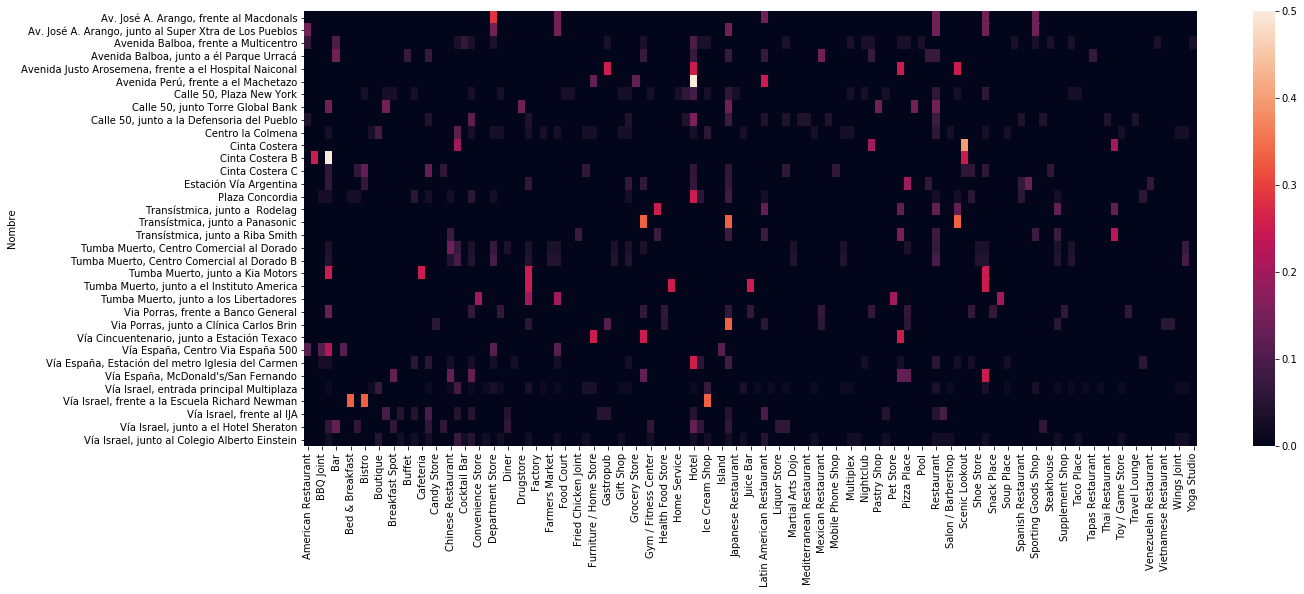

In [314]:
df_cluster_0 = df_clustering_points.loc[df_clustering_points['Cluster Labels'] == 0, df_clustering_points.columns[[1] + list(range(5, df_clustering_points.shape[1]))]]
plot_heatmap(df_cluster_0)

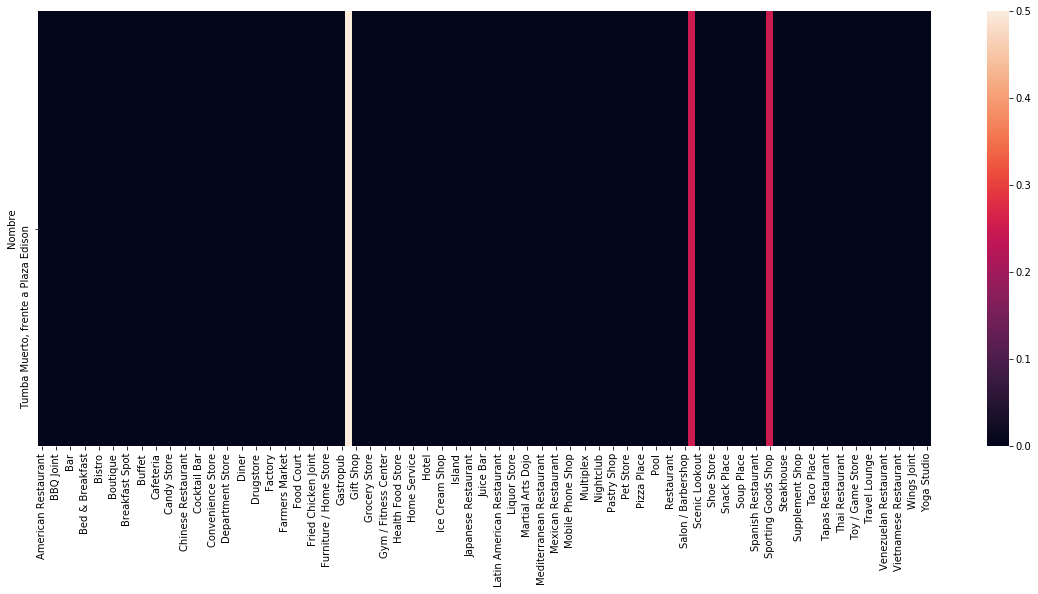

In [315]:
df_cluster_1 = df_clustering_points.loc[df_clustering_points['Cluster Labels'] == 1, df_clustering_points.columns[[1] + list(range(5, df_clustering_points.shape[1]))]]
plot_heatmap(df_cluster_1)

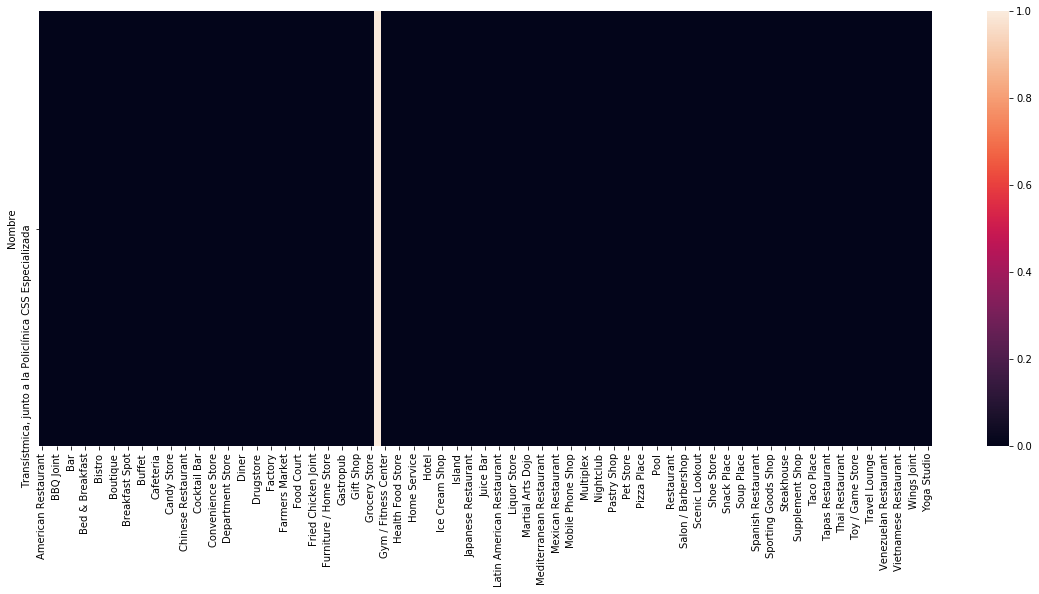

In [316]:
df_cluster_2 = df_clustering_points.loc[df_clustering_points['Cluster Labels'] == 2, df_clustering_points.columns[[1] + list(range(5, df_clustering_points.shape[1]))]]
plot_heatmap(df_cluster_2)

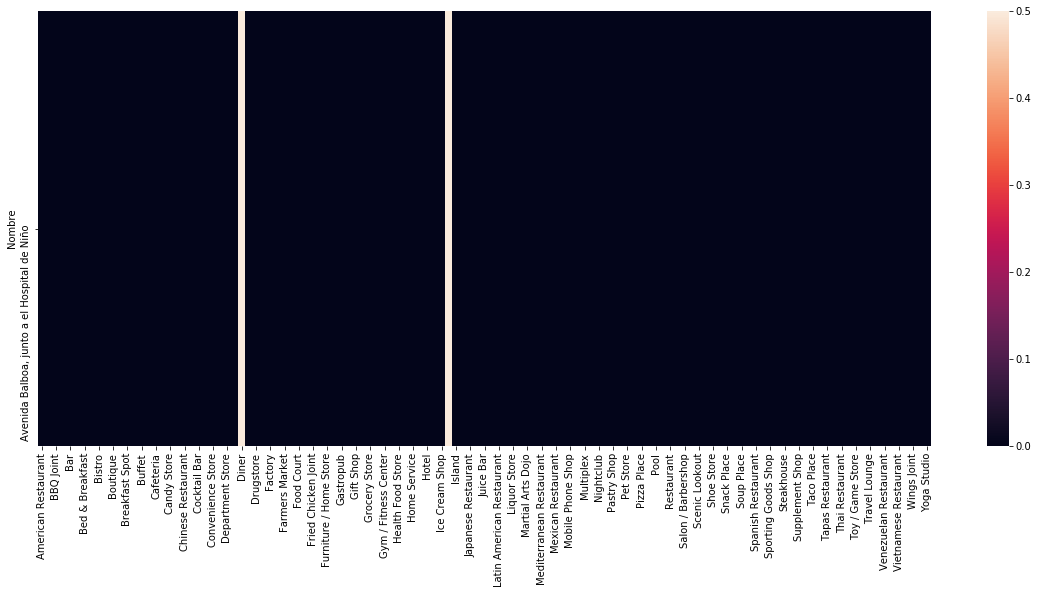

In [317]:
df_cluster_3 = df_clustering_points.loc[df_clustering_points['Cluster Labels'] == 3, df_clustering_points.columns[[1] + list(range(5, df_clustering_points.shape[1]))]]
plot_heatmap(df_cluster_3)

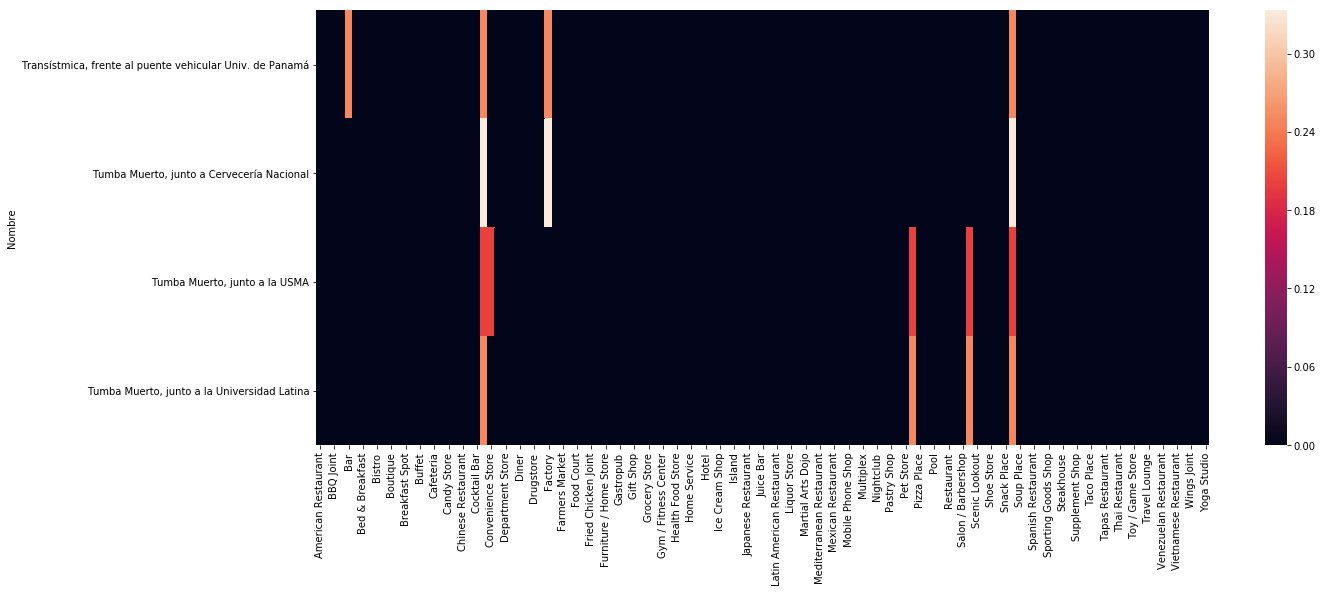

In [318]:
df_cluster_4 = df_clustering_points.loc[df_clustering_points['Cluster Labels'] == 4, df_clustering_points.columns[[1] + list(range(5, df_clustering_points.shape[1]))]]
plot_heatmap(df_cluster_4)

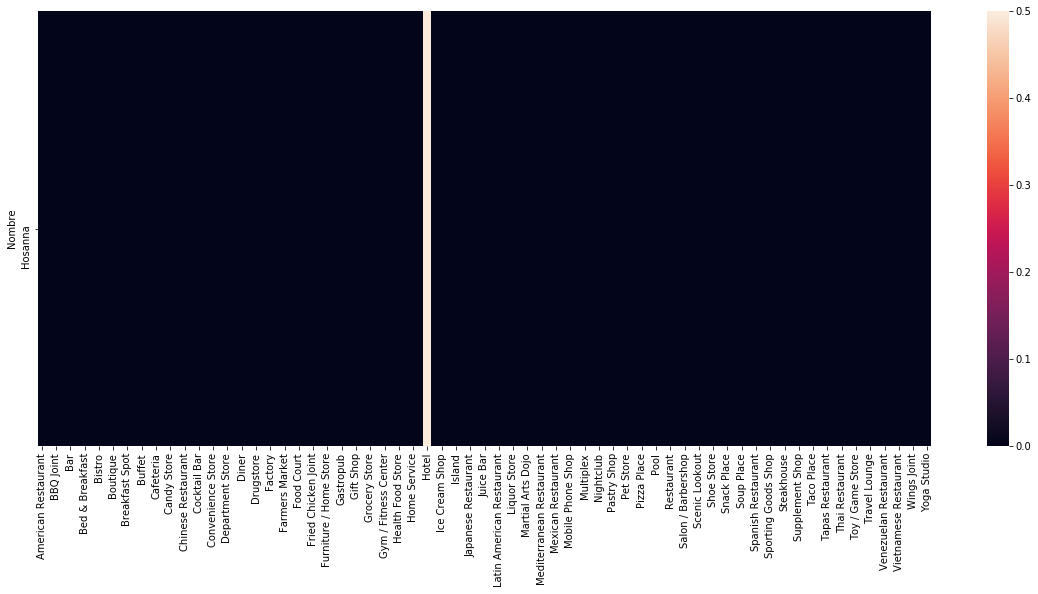

In [319]:
df_cluster_5 = df_clustering_points.loc[df_clustering_points['Cluster Labels'] == 5, df_clustering_points.columns[[1] + list(range(5, df_clustering_points.shape[1]))]]
plot_heatmap(df_cluster_5)

### Results and Discussion

Our analysis shows the distribution of smart points around the city using 6 groups of segmentations. For each group we have collected the patterns about how many kinds of places are around them. This is what we have:

- **Cluster 1**: This the first and more difficult group to understand. If we see the final Map, we see that the red colors (cluster 1) are in the whole center of the city. They represent the majority of points and this is a great insight which means the majority of points are in the same category of places. What kind of places? The heatmap shows a particular pattern that others clusters don't have. If we see the majority of the avenues have places for Food and drinks. No so many are about hotel, barbers, shops, etc. So maybe people are more prone to be in these places, spending their times with friends and drinking or having a lunch than in another side of the city. This is a great insight for business because this cluster represent the first option for create business strategies using The Smart Points.

- **Cluster 2**: In this cluster, there is just one avenue which is *Tumba Muerto frente a plaza edison*. Analyzing the heatmap we can understand that this is a place just for make shopping. So, in the smart point people that are close to this point could be here just for that.

- **Cluster 3**: In this cluster, the heatmap tell us that this is a zone just for grocery stores. The measure is in 50%, so i think it's a good zone for strategies with groceries.

- **Cluster 4**: This cluster have just one avenue too which is *Transistmica junto a policlinica..*. It also doesn't seems like a special point. I don't think this could be a good place for marketing strategies either.

- **Cluster 5**: This group is the closest to 'group 1'. According to the cluster, this area is for places that offer drinks and food, very similar to cluster 1. It is also important to comply with the largest number of avenues, after cluster 1.

- **Cluster 6**: In this cluster is just one avenue, `Hosana`. But, according to the heatmap, this is a place close to hotels or just one hotel.

According to this studio, we can define the following:

- The majority of Smart Points belongs or are close to places where people are prone to be. Places like bars, restaurants, groceries, hotels. This is important to understand because we can be sure that maybe at the beginning, the company did a great job trying to distributed the points with a strategy.
- We have now 6 kinds of clusters and we can define it in the following way: places where people are prone to be --> Places where people are not use to being.
- The most commons places are about: Food, Bars and groceries.

### Conclusion

Our studio was created to understand how the smart points are distributed around the city. The measure of the studio was define by two points:

1. The main data, which is the smart points locations.
2. Foursquare API.

Using these tools, we were able to made a complete analysis about the smart points. We discover the most commons places and also a way to create a model group for future distributions, which means how can be locate it a new point based on this studio.

However, it's important to clarify just one concern:

While we have been using Foursquare API to create our exploration data, we need to use a better API with more accuracy data for next studios. Foursquare API doesn't has the whole locations of the city or even all the places (stores, hotels, parks, etc.). So, for future studios, we need to use another API with more accuracy data about The city of Panamá. Foursquare API was not able to recover data from the
point `Transístmica, junto a Escuela de Artes y Oficios`, which could be important for the final analysis.